In [80]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, FreqDist

from wordcloud import WordCloud

import pickle

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300 # max width of a column

%matplotlib inline


In [18]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gburgess/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [2]:
jigsaw_df = pd.read_csv('../data/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv')

In [3]:
is_toxic = (jigsaw_df['toxicity'] >= 0.5) | (jigsaw_df['severe_toxicity'] >= 0.1) | \
            (jigsaw_df['obscene'] >= 0.25) | (jigsaw_df['sexual_explicit'] >= 0.25) | \
            (jigsaw_df['identity_attack'] >= 0.25) | (jigsaw_df['insult'] >= 0.25) | \
            (jigsaw_df['threat'] >= 0.10)

In [4]:
new_target_df = pd.DataFrame()
new_target_df[['id', 'comment_text']] = jigsaw_df[['id', 'comment_text']].copy()
new_target_df['target'] = (is_toxic).astype(int)
new_target_df.info(show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999516 entries, 0 to 1999515
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   id            1999516 non-null  int64 
 1   comment_text  1999515 non-null  object
 2   target        1999516 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 45.8+ MB


In [5]:
# remove single row with NaN in `comment_text` (probably there just for fun!)
new_target_df.dropna(inplace=True)

In [83]:
# # save new df to reuse it later without re-creating it
# new_target_df.to_csv('../data/new_target_df.csv', index=False)

# # load new df so you don't need to re-create it
# new_target_df = pd.read_csv('../data/new_target_df.csv')

In [6]:
del jigsaw_df

In [7]:
is_target = (new_target_df['target'] == 1)
num_targets = sum(is_target)
num_targets

338409

In [8]:
majority_df = resample(new_target_df[ is_target ],
                       replace=False,
                       n_samples=num_targets,
                       random_state=42)

minority_df = resample(new_target_df[ ~is_target ],
                       replace=False,
                       n_samples=num_targets,
                       random_state=42)

train_df = pd.concat([majority_df, minority_df])
train_df['target'].value_counts()

1    338409
0    338409
Name: target, dtype: int64

In [9]:
y = train_df['target']
X = train_df['comment_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [10]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
sw = stopwords.words('english')

def word_processor(comment, stopword_list=sw):
    # tokenize (simultaneously removes punctuation)
    tokenizer = RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)")
    words = tokenizer.tokenize(comment)

    # lowercase and remove stopwords
    words = [word.lower() for word in words if word.lower() not in stopword_list]
    
    # lemmatize (accounting for part of speech)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1])) 
             for word in pos_tag(words)]

    return words

In [14]:
X_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 507613 entries, 1483102 to 1422804
Series name: comment_text
Non-Null Count   Dtype 
--------------   ----- 
507613 non-null  object
dtypes: object(1)
memory usage: 7.7+ MB


In [15]:
train_df = pd.concat([y_train, X_train], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507613 entries, 1483102 to 1422804
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   target        507613 non-null  int64 
 1   comment_text  507613 non-null  object
dtypes: int64(1), object(1)
memory usage: 11.6+ MB


In [19]:
%%time
train_df['proc_text'] = list(map(word_processor, train_df['comment_text']))

CPU times: user 13min 5s, sys: 8.65 s, total: 13min 14s
Wall time: 13min 17s


In [24]:
is_target = (train_df['target'] == 1)

for i in range(3):
    print("Target comment before tokenizing: ", train_df[is_target]['comment_text'].iloc[i])
    print("Target comment after tokenizing :", train_df[is_target]['proc_text'].iloc[i])
    print()

for i in range(3):
    print("Non-target comment before tokenizing: ", train_df[~is_target]['comment_text'].iloc[i])
    print("Non-target comment after tokenizing :", train_df[~is_target]['proc_text'].iloc[i])
    print()

Target comment before tokenizing:  Dead On Arrival......won't ever pass!
Target comment after tokenizing : ['dead', 'arrival', 'ever', 'pas']

Target comment before tokenizing:  Drain the swamp? Really?  Suckers!!!!
Target comment after tokenizing : ['drain', 'swamp', 'really', 'sucker']

Target comment before tokenizing:  I will confirm your statement.  I have worked with most of the employees that were put through hell by this government.  The thing that continues to bother me is that the lead investigator ended up being promoted and moved out of the ministry where she continues in an executive position with high pay but has no staff.  Everybody concerned that brought on this hell has ended up being protected by the liberals with promotions or nice severance packages.  Just remember when you vote in May on the type of government you want.
Target comment after tokenizing : ['confirm', 'statement', 'work', 'employee', 'put', 'hell', 'government', 'thing', 'continue', 'bother', 'lead', 

In [46]:
bully_train_df = train_df[is_target]

In [47]:
bully_train_df.head()

,target,comment_text,proc_text
1483102,1,Dead On Arrival......won't ever pass!,"[dead, arrival, ever, pas]"
132094,1,Drain the swamp? Really? Suckers!!!!,"[drain, swamp, really, sucker]"
1486986,1,I will confirm your statement. I have worked with most of the employees that were put through hell by this government. The thing that continues to bother me is that the lead investigator ended up being promoted and moved out of the ministry where she continues in an executive position with hig...,"[confirm, statement, work, employee, put, hell, government, thing, continue, bother, lead, investigator, end, promote, moved, ministry, continue, executive, position, high, pay, staff, everybody, concern, brought, hell, end, protect, liberal, promotion, nice, severance, package, remember, vote, ..."
1351710,1,"I suspect Bush's reticence to open his mouth has something to do with that old bit of folk wisdom about ""people in glass houses who've committed a slew of war crimes"" not throwing stones and all. Besides, I think it's hard for Bush to string sentences together without Cheney's hand up his backs...","[suspect, bush's, reticence, open, mouth, something, old, bit, folk, wisdom, people, glass, house, who've, commit, slew, war, crime, throw, stone, besides, think, hard, bush, string, sentence, together, without, cheney's, hand, backside]"
401223,1,"Also if there is a catastrophe which we hope will not happen, but if it does federal aid will be very slow because Ige and Chin will make this a sanctuary state and it will be there fault for the slow aid we get, or the federal aid we get some of it could be cut off because of our sanctuary stat...","[also, catastrophe, hope, happen, federal, aid, slow, ige, chin, make, sanctuary, state, fault, slow, aid, get, federal, aid, get, could, cut, sanctuary, state, status, happen, blame, clown, two, state, mayor]"


In [ ]:
# ### Load corpus lists in from pickle (to avoid re-running)
# filename = "../data/corpus_dict.pkl"

# open_file = open(filename, "rb")
# corpus_dict = pickle.load(open_file)
# open_file.close()

# bully_corpus_list = corpus_dict['bully_corpus_list']
# nonbully_corpus_list = corpus_dict['nonbully_corpus_list']

In [48]:
%%time
bully_corpus_list = sum(bully_train_df['proc_text'], [])

CPU times: user 4h 48min 53s, sys: 20min 58s, total: 5h 9min 51s
Wall time: 5h 10min 19s


In [50]:
%%time
bully_freq_dist = FreqDist(bully_corpus_list)

CPU times: user 4.01 s, sys: 40.2 ms, total: 4.05 s
Wall time: 4.08 s


In [51]:
bully_freq = pd.Series(dict(bully_freq_dist.most_common(20)))

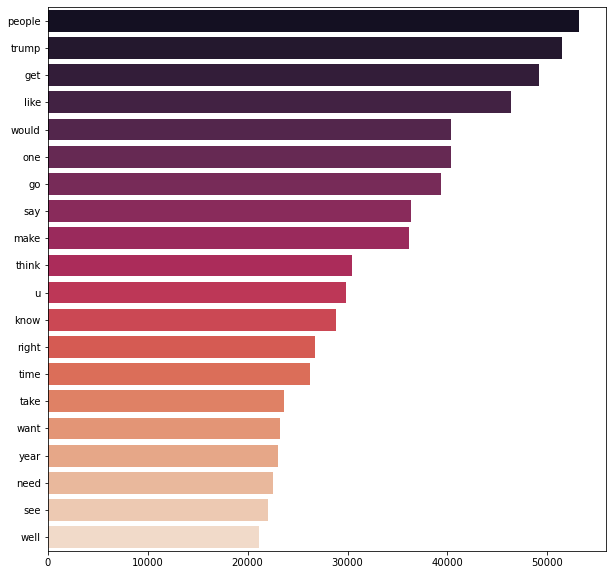

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
bully_plot = sns.barplot(x=bully_freq.values, y=bully_freq.index, ax=ax, palette="rocket")
plt.savefig('../images/bully_FreqDist.jpg', transparent = False, bbox_inches="tight")

In [49]:
nonbully_train_df = train_df[~is_target]
nonbully_train_df.head()

,target,comment_text,proc_text
643238,0,You would think the Springfield Police have better things to do other than ticketing those drivers and passengers who donate. Where will the proposed $50 fine go? To help the unhoused in some way? To hear Springfield councilors talk about all the services they provide for the homeless is nothing...,"[would, think, springfield, police, well, thing, ticket, driver, passenger, donate, propose, fine, go, help, unhoused, way, hear, springfield, councilors, talk, service, provide, homeless, nothing, attempt, put, lipstick, pig, supporter, ordinance, imagine, donation, go, drug, alcohol, adult, kn..."
415740,0,"I asked first.\n\nThe point is that if we can't identify how a non-binary person is supposed to look, then it's not useful information on an ID card used to verify your identity.\n\nBy contrast, we can generally identify people's sex just by looking at their body size and shape, even if they're...","[ask, first, point, can't, identify, non, binary, person, suppose, look, useful, information, id, card, use, verify, identity, contrast, generally, identify, people's, sex, look, body, size, shape, even, they're, wear, jean, shirt]"
1988667,0,well if it's not a crime then hey give me a job I love to Sip and Grandpa's old cough syrup well I'm teaching the kids to do as I say not as I do. now hate me Islanders.,"[well, crime, hey, give, job, love, sip, grandpa's, old, cough, syrup, well, i'm, teach, kid, say, hate, islander]"
1878442,0,trudeau cut oas and then gave khadr 10 million we now know he loves his muslim buddy,"[trudeau, cut, oas, give, khadr, million, know, love, muslim, buddy]"
78890,0,I see no sign of imminent collapse....up 4% YTD\nAs long as you only hold 8-10 positions you can vaporize them for $80\nAlso high yield (US) bond ETF's can get you 5.7%....better than nothing.,"[see, sign, imminent, collapse, ytd, long, hold, position, vaporize, also, high, yield, u, bond, etf's, get, good, nothing]"


In [53]:
%%time
nonbully_corpus_list = sum(nonbully_train_df['proc_text'], [])

CPU times: user 4h 49min 5s, sys: 20min 50s, total: 5h 9min 55s
Wall time: 5h 9min 26s


In [54]:
%%time
nonbully_freq_dist = FreqDist(nonbully_corpus_list)

CPU times: user 3.85 s, sys: 60.2 ms, total: 3.91 s
Wall time: 3.92 s


In [56]:
nonbully_freq = pd.Series(dict(nonbully_freq_dist.most_common(20)))

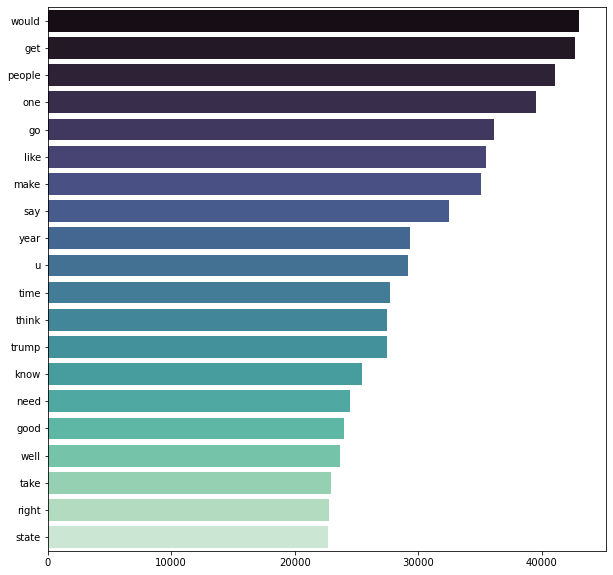

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
nonbully_plot = sns.barplot(x=nonbully_freq.values, y=nonbully_freq.index, ax=ax, palette="mako")
plt.savefig('../images/nonbully_FreqDist.jpg', transparent = False, bbox_inches="tight")

In [82]:
# ### Save corpus lists to pickle file (nested in dictionary)
# corpus_dict = {
#     'bully_corpus_list': bully_corpus_list,
#     'nonbully_corpus_list': nonbully_corpus_list
# }
# filename = "../data/corpus_dict.pkl"
# open_file = open(filename, "wb")
# pickle.dump(corpus_dict, open_file)
# open_file.close()

In [68]:
wordcloud = WordCloud(min_font_size=10, max_font_size=100, 
                      width=2000, height=2000).generate_from_frequencies(dict(bully_freq_dist));
#wordcloud.to_file("../images/bully_wordcloud.png")

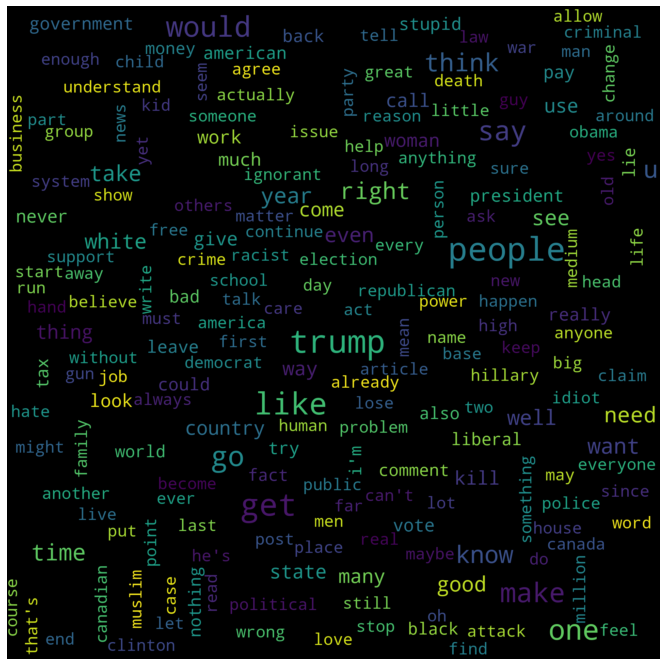

In [69]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

In [70]:
wordcloud = WordCloud(min_font_size=10, max_font_size=100, 
                      width=2000, height=2000,
                      background_color='white').generate_from_frequencies(dict(nonbully_freq_dist));
#wordcloud.to_file("../images/nonbully_wordcloud.png")

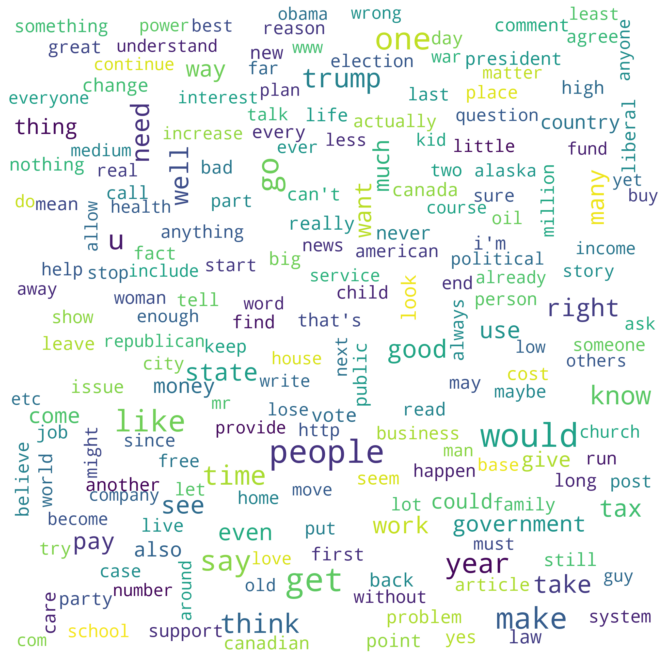

In [71]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");